### Parses large `results.csv` file generated by `run_evaluations.sh` 

In [1]:
# !pip install -U pandas # 1.4.2

In [150]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

plot_path = Path('/home/user/kew/INSTALLS/fudge/analysis/plots')

In [151]:
assert pd.__version__ == "1.4.2"

In [152]:
# Update (1/11/22): adapted to include BERTscore computed against ref AND src sentence (for meaning preservation)

mapping = {
    'test_set': 'Target Level',
    'params': 'Method',
    'sari': 'SARI',
    'bertscore_f1_ref': 'BERTScore (ref)',
    'bertscore_f1_src': 'BERTScore (src)',
    'bleu': 'BLEU',
    'fkgl': 'FKGL',
    'intra_dist1': 'Dist-1',
    'ppl': 'PPL',
    'Compression ratio': 'Comp. ratio', 
    'Sentence splits': 'Sent. splits',
    'Levenshtein similarity': 'Lev. sim.',
    'Exact copies': 'Copies', 
    'Additions proportion': 'Add prop.',
    'Deletions proportion': 'Del prop.',
}

\begin{tabular}{lrrrrrrr}
 & FKGL & Comp. ratio & Sent. splits & Lev. sim. & Copies & Add prop. & Del prop. \\
Simp-1 & 7.97 & 1.01 & 1.19 & 0.90 & 0.44 & 0.10 & 0.10 \\
Simp-2 & 6.41 & 0.98 & 1.42 & 0.82 & 0.23 & 0.17 & 0.20 \\
Simp-3 & 4.91 & 0.92 & 1.55 & 0.73 & 0.13 & 0.24 & 0.31 \\
Simp-4 & 3.40 & 0.85 & 1.79 & 0.65 & 0.09 & 0.30 & 0.43 \\
\end{tabular}



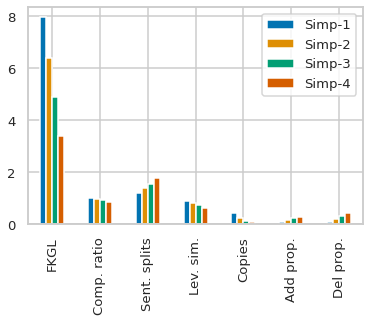

In [153]:
ground_truth = {
    'Simp-1': {'FKGL': 7.967424772673326, 'Comp. ratio': 1.0088417673071652, 'Sent. splits': 1.1946118721461185, 'Lev. sim.': 0.9038902274159766, 'Copies': 0.4410958904109589, 'Add prop.': 0.09501851581521988, 'Del prop.': 0.0990403784826063, 'Lexical complexity score': 8.55938268290073}, 
    'Simp-2': {'FKGL': 6.411884361286063, 'Comp. ratio': 0.9812542863921209, 'Sent. splits': 1.4155807365439093, 'Lev. sim.': 0.8199736978615051, 'Copies': 0.22946175637393768, 'Add prop.': 0.17032500978943574, 'Del prop.': 0.1987557520780373, 'Lexical complexity score': 8.517484017433077}, 
    'Simp-3': {'FKGL': 4.9119896238676795, 'Comp. ratio': 0.9246498121085542, 'Sent. splits': 1.5486515641855447, 'Lev. sim.': 0.7346835852500192, 'Copies': 0.13268608414239483, 'Add prop.': 0.24369044331926637, 'Del prop.': 0.3137163907153821, 'Lexical complexity score': 8.467478933429538},
    'Simp-4': {'FKGL': 3.3956874275197073, 'Comp. ratio': 0.8485376584110984, 'Sent. splits': 1.7920572916666666, 'Lev. sim.': 0.6461078981377691, 'Copies': 0.08984375, 'Add prop.': 0.2994676753866754, 'Del prop.': 0.4317465655764906, 'Lexical complexity score': 8.525171061087843}
    }

gdf = pd.DataFrame(ground_truth)

gdf.drop(index=['Lexical complexity score'], inplace=True)
gdf.plot(kind='bar')

gdf = gdf.transpose().rename(columns=mapping)
gdf = gdf.style.format(na_rep='-', precision=2)
print(gdf.to_latex())

In [154]:
def parse_muss_path(file_path):
    cond_model = ''
    file_name = file_path[-1] # newsela_manual_v0_v2_dev_lr0.75_ls0.82_wr0.94_td0.22.pred
    test_set = '_'.join(file_name.split('_')[:5])
    params = 'MUSS' #','.join(file_name.split('_')[5:]).rstrip('.pred')
    return cond_model, test_set, params

def parse_fudge_path(file_path):
    cond_model = file_path[8].split('_')[1].upper()
    test_set = file_path[9]
    params = file_path[-1]
    return cond_model, test_set, params

def parse_supervised_path(file_path):
    # /srv/scratch6/kew/ats/supervised/newsela_manual/results/newsela_manual_v0_v4_test/lambda0.0*
    print(file_path)
    cond_model = ''
    test_set = file_path[8]
    # HR indicates model trained on newsela-auto aligned training set (~317,849 instances)
    # LR indicates model trained on newsela-MANUAL aligned training set (~4,469 instances)
    params = 'SUPER-LR' if file_path[6] == 'newsela_manual' else 'SUPER-HR'
    return cond_model, test_set, params

def get_file_info(file_path):
    file_path = file_path.split('/')
    method = file_path[5]
    if method == 'fudge':
        cond_model, test_set, params = parse_fudge_path(file_path)
    elif method == 'muss':
        cond_model, test_set, params = parse_muss_path(file_path)
    elif method == 'supervised':
        cond_model, test_set, params = parse_supervised_path(file_path)
    return method, cond_model, test_set, params

def filter_rows(df):

    df = df[df["params"].str.contains("pretopk100|lambda5.0")==False].reset_index(drop=True)
    # ignore results from inference runs with default lambda=5.0 and pretopk=100
    return df
   
def read_data(csv_file):
    df = pd.read_csv(
        csv_file, 
        header=0, 
        sep=';',
    )

    df['method'], df['cond_model'], df['test_set'], df['params'] = zip(*df['file'].apply(get_file_info))
    
    df['split'] = df['test_set'].apply(lambda x: x.split('_')[-1])
    df['test_set'] = df['test_set'].apply(
        lambda x: ' '.join(x.split('_')[3:4]).replace('v', 'Simp-'))

    # characters for plotting
    df['cond_model'] = df['cond_model'].apply(lambda x: re.sub('L', 'ℬ_Simp-', x))
    df['params'] = df['params'].apply(lambda x: x.split('_')[0].replace('lambda', 'λ='))

    # characters for latex
    df['params'] = df.apply(lambda x: f"{str(x.cond_model)} {str(x.params)}", axis=1)
    df['params'] = df['params'].apply(lambda x: x.replace('ℬ_Simp-', '$\mathcal{B}_{Simp-}'))
    df['params'] = df['params'].apply(lambda x: x.replace('{Simp-}1', '{Simp-1}')) # hack
    df['params'] = df['params'].apply(lambda x: x.replace('{Simp-}2', '{Simp-2}'))
    df['params'] = df['params'].apply(lambda x: x.replace('{Simp-}3', '{Simp-3}'))
    df['params'] = df['params'].apply(lambda x: x.replace('{Simp-}4', '{Simp-4}'))
    # df['params'] = df['params'].apply(lambda x: x.replace('λ=', '\lambda=$',))
    df['params'] = df['params'].apply(lambda x: x.replace('λ=', '$'))
    # df['params'] = df['params'].apply(lambda x: x[:-3])
    
#     print(df['params'])
    df.sort_values(['split', 'test_set', 'method', 'params'], inplace=True)
    
#     TODO: replace \lambda=$0.0 with $\mathcal{G}$
    df['params'] = df['params'].apply(lambda x: '$\mathcal{G}$' if '0.0' in x else x)
#     df['method'] = df.loc[df['params'].str.contains('0.0'), 1] = '$\mathcal{G}$'
    
    return df.reset_index(drop=True, inplace=False)

def generate_results_table_for_controlled_simplification_levels(df):
    # very rudimentary method for filtering 'unwanted' rows for a particular table/plot

    df = df[df["file"].str.contains("pretopk100")==False]
    df = df[(df["test_set"].str[-2:] == df["params"].str[:2]) | (df["method"] != "fudge")]
    df = df[(df["test_set"] != "L0-L4") | (df["params"].str.contains("L4-lambda4.0|L4-lambda5.0")==False)]
    return df.reset_index(drop=True, inplace=False)

def generate_results_table_for_newsela4_classifier_on_all_levels(df):
    # very rudimentary method for filtering 'unwanted' rows for a particular table/plot

    print(len(df))
    df = df[df["file"].str.contains("pretopk100")==False]
    print(len(df))
    ignore_settings = [
        "L1-lambda0.0", "L1-lambda1.0", "L1-lambda8.0", 
        'L2-lambda0.0', "L2-lambda1.0", "L2-lambda10.0",
        "L3-lambda0.0", "L3-lambda1.0", "L3-lambda10.0", 
        "L4-lambda0.0",
    ]
    df = df[df["params"].isin(ignore_settings)==False]
    print(len(df))

    df = df[((df["params"] == "L4-lambda5.0") & (df["test_set"] != "L0-L3"))==False]
    df = df[((df["params"] == "L4-lambda1.0") & (df["test_set"] == "L0-L4"))==False]
    print(len(df))
    
    return df.reset_index(drop=True, inplace=False)


def generate_large_results_table_article_paragraphs(df):
    # very rudimentary method for filtering 'unwanted' rows for a particular table/plot

    print(len(df))
    df = df[df["file"].str.contains("pretopk100")==False]
    print(len(df))
    df = df[((df["params"] == "L4-lambda5.0") & (df["test_set"] == "L0-L1"))==False]
    df = df[((df["params"] == "L4-lambda5.0") & (df["test_set"] == "L0-L2"))==False]
    print(len(df))
    
    return df.reset_index(drop=True, inplace=False)


def generate_large_results_table_article_para_sents(df):
    # very rudimentary method for filtering 'unwanted' rows for a particular table/plot

    df = df[df["file"].str.contains("pretopk100")==False]
    df = df[(df['file'].str.contains('article_paragraphs'))==False]
    df = df[(df['file'].str.contains('newsela_l4_article_para_sents/newsela_manual_v0_v1_test/lambda0.0'))==False]
    df = df[(df['file'].str.contains('newsela_l2_article_para_sents/newsela_manual_v0_v2_test/lambda1.0'))==False]
#     df = df[(df['file'].str.contains('newsela_l4_article_para_sents/newsela_manual_v0_v2_test/lambda2.0'))==False]
    df = df[(df['file'].str.contains('newsela_l3_article_para_sents/newsela_manual_v0_v3_test/lambda1.0'))==False]
#     df = df[(df['file'].str.contains('newsela_l4_article_para_sents/newsela_manual_v0_v3_test/lambda6.0'))==False]
    df = df[(df['file'].str.contains('newsela_l4_article_para_sents/newsela_manual_v0_v1_test/lambda0.0'))==False]
    df = df[(df['file'].str.contains('newsela_l4_article_para_sents/newsela_manual_v0_v4_test/lambda1.0'))==False]

    df.reset_index(drop=True, inplace=False)
    
    df = df.rename(columns=mapping)
    df = df[list(mapping.values())]
    
    return df


def generate_large_results_table_lp_article_paragraphs(df):
    # very rudimentary method for filtering 'unwanted' rows for a particular table/plot

    df = df[df["file"].str.contains("pretopk100")==False]
    # simp-1
    #     df = df[df["file"].str.contains("/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l1_article_para_sents/newsela_manual_v0_v1_test/lambda0.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt")]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l1_article_paragraphs/newsela_manual_v0_v1_test/lambda0.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l1_article_para_sents/newsela_manual_v0_v1_test/lambda1.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l1_article_paragraphs/newsela_manual_v0_v1_test/lambda1.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l1_article_paragraphs/newsela_manual_v0_v1_test/lambda8.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_para_sents/newsela_manual_v0_v1_test/lambda0.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_paragraphs/newsela_manual_v0_v1_test/lambda1.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_paragraphs/newsela_manual_v0_v1_test/lambda5.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_paragraphs/newsela_manual_v0_v1_test/lambda2.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    
    # simp-2
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_paragraphs/newsela_manual_v0_v1_test/lambda2.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l2_article_para_sents/newsela_manual_v0_v2_test/lambda1.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l2_article_para_sents/newsela_manual_v0_v2_test/lambda0.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]    
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l2_article_paragraphs/newsela_manual_v0_v2_test/lambda1.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l2_article_paragraphs/newsela_manual_v0_v2_test/lambda10.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_paragraphs/newsela_manual_v0_v2_test/lambda2.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l2_article_para_sents/newsela_manual_v0_v2_test/lambda7.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_paragraphs/newsela_manual_v0_v2_test/lambda5.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_para_sents/newsela_manual_v0_v2_test/lambda2.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_paragraphs/newsela_manual_v0_v2_test/lambda3.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]

    # simp-3
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l3_article_para_sents/newsela_manual_v0_v3_test/lambda0.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l3_article_para_sents/newsela_manual_v0_v3_test/lambda1.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l3_article_paragraphs/newsela_manual_v0_v3_test/lambda1.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l3_article_paragraphs/newsela_manual_v0_v3_test/lambda10.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l3_article_para_sents/newsela_manual_v0_v3_test/lambda7.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l3_article_para_sents/newsela_manual_v0_v3_test/lambda5.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_paragraphs/newsela_manual_v0_v3_test/lambda3.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]    
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_paragraphs/newsela_manual_v0_v3_test/lambda5.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_paragraphs/newsela_manual_v0_v3_test/lambda6.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"] 
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_para_sents/newsela_manual_v0_v3_test/lambda6.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    
    # simp-4
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_para_sents/newsela_manual_v0_v4_test/lambda0.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]    
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_para_sents/newsela_manual_v0_v4_test/lambda1.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_paragraphs/newsela_manual_v0_v4_test/lambda1.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_paragraphs/newsela_manual_v0_v4_test/lambda4.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_paragraphs/newsela_manual_v0_v4_test/lambda5.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_paragraphs/newsela_manual_v0_v4_test/lambda7.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != "/srv/scratch6/kew/ats/fudge/results/bart_large_muss_mined_en/newsela_l4_article_para_sents/newsela_manual_v0_v4_test/lambda8.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.2_softFalse_temp1.0_topk0_topp1.0_bs1.txt"]
    df = df[df["file"] != ""]
    df = df[df["file"] != ""]

    df.reset_index(drop=True, inplace=False)
    
    df = df.rename(columns=mapping)
    df = df[list(mapping.values())]
    
    return df


df = read_data('/home/user/kew/INSTALLS/fudge/results/test.csv')
df = generate_large_results_table_lp_article_paragraphs(df)

['', 'srv', 'scratch6', 'kew', 'ats', 'supervised', 'newsela_manual', 'results', 'newsela_manual_v0_v1_test', 'lambda0.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.0_softFalse_temp1.0_topk0_topp1.0_bs1.txt']
['', 'srv', 'scratch6', 'kew', 'ats', 'supervised', 'newsela_manual', 'results', 'newsela_manual_v0_v2_test', 'lambda0.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.0_softFalse_temp1.0_topk0_topp1.0_bs1.txt']
['', 'srv', 'scratch6', 'kew', 'ats', 'supervised', 'newsela_manual', 'results', 'newsela_manual_v0_v3_test', 'lambda0.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.0_softFalse_temp1.0_topk0_topp1.0_bs1.txt']
['', 'srv', 'scratch6', 'kew', 'ats', 'supervised', 'newsela_manual', 'results', 'newsela_manual_v0_v4_test', 'lambda0.0_pretopk200_beams5_estopFalse_maxl128_minl10_sampleFalse_lp1.0_norep1_bgrps1_nbest5_repp1.0_softFalse_temp1.0_topk0_to

,Target Level,Method,SARI,BERTScore (ref),BERTScore (src),BLEU,FKGL,Dist-1,PPL,Comp. ratio,Sent. splits,Lev. sim.,Copies,Add prop.,Del prop.
0,Simp-1,$\mathcal{G}$,36.609072,81.675690,90.054548,65.159409,9.152054,0.915912,100.667176,0.974721,1.015068,0.885676,0.175342,0.079782,0.108260
4,Simp-1,$\mathcal{B}_{Simp-1} $1.0,36.104563,80.445397,88.547665,61.682602,8.812060,0.921739,102.135770,0.941372,1.006256,0.875990,0.131507,0.074644,0.134177
11,Simp-1,MUSS,35.689195,75.949240,82.263905,50.607168,7.752044,0.937497,89.728976,0.811370,1.003425,0.844320,0.013699,0.074010,0.235342
12,Simp-1,SUPER-HR,38.666065,87.258750,96.193427,75.533239,9.059812,0.923445,4810.661861,0.958171,1.000000,0.966785,0.810959,0.007094,0.045650
13,Simp-1,SUPER-LR,32.494886,88.186944,98.418158,78.491987,9.357700,0.920551,90.290567,0.991141,1.038813,0.990262,0.887671,0.006629,0.014658
15,Simp-2,$\mathcal{G}$,35.006925,73.534739,90.012091,52.844353,9.124967,0.915279,101.401515,0.973018,1.015581,0.885422,0.178470,0.079974,0.109788
19,Simp-2,$\mathcal{B}_{Simp-2} $4.0,38.324349,70.747864,84.409726,48.024293,7.422022,0.908133,110.919863,0.964747,1.251747,0.840843,0.079320,0.122507,0.170452
26,Simp-2,MUSS,36.566496,65.907264,76.076239,28.724531,7.269932,0.941795,176.126387,0.778172,1.025260,0.752531,0.002833,0.147472,0.345488
27,Simp-2,SUPER-HR,42.235408,74.616396,88.019162,53.532680,7.537077,0.936894,4947.957481,0.859335,0.996317,0.886190,0.569405,0.018270,0.152244
28,Simp-2,SUPER-LR,31.119814,78.216690,96.989560,61.781532,8.877532,0.919900,107.541607,0.990798,1.095467,0.978994,0.796034,0.015011,0.026788


In [178]:
cm_asc = sns.light_palette("#2ecc71", as_cmap=True)
cm_desc = sns.light_palette("#2ecc71", as_cmap=True, reverse=True)

def get_closest(s, props='', tgt_val=None):
    closest = min(s, key=lambda x: abs(x-tgt_val))
    return np.where(s == closest, props, '')

def make_pretty(styler, max_cols=['SARI', 'BERTScore (ref)', 'BERTScore (src)'], min_cols=['FKGL'], hidden_cols=['BLEU'], kwargs=None):
    # Update (1/11/22): adapted to include BERTscore computed against ref AND src sentence (for meaning preservation)
    styler.background_gradient(cmap=cm_asc, axis=0, subset=max_cols)

    styler.format(na_rep='-', precision=2)
    styler.apply(get_closest, props='font-weight:bold', axis=0, subset=['FKGL'], tgt_val=kwargs['FKGL'])
    styler.apply(get_closest, props='font-weight:bold', axis=0, subset=['Comp. ratio'], tgt_val=kwargs['Comp. ratio'])
    styler.apply(get_closest, props='font-weight:bold', axis=0, subset=['Sent. splits'], tgt_val=kwargs['Sent. splits'])
    styler.apply(get_closest, props='font-weight:bold', axis=0, subset=['Lev. sim.'], tgt_val=kwargs['Lev. sim.'])
    styler.apply(get_closest, props='font-weight:bold', axis=0, subset=['Copies'], tgt_val=kwargs['Copies'])
    styler.apply(get_closest, props='font-weight:bold', axis=0, subset=['Add prop.'], tgt_val=kwargs['Add prop.'])
    styler.apply(get_closest, props='font-weight:bold', axis=0, subset=['Del prop.'], tgt_val=kwargs['Del prop.'])

    return styler

# seperate tables per tgt level
for tlvl in df['Target Level'].unique():
    print(tlvl)
    print()
    sub_df = df[df['Target Level'] == tlvl]
    sub_df = sub_df.set_index(['Target Level', 'Method']).drop(columns=['BLEU', 'Dist-1', 'PPL'])
    sub_df = sub_df.style.pipe(make_pretty, kwargs=ground_truth[tlvl])
    print(sub_df.to_latex(
        column_format=f'@{{}}{"X"*(len(sub_df.columns)+len(sub_df.index.names))}@{{}}',
        hrules=False, 
        convert_css=True,
        sparse_index=True,
        sparse_columns=True,
        multirow_align='c',
        multicol_align='c',
    ))

Simp-1

\begin{tabular}{@{}XXXXXXXXXXXX@{}}
 &  & SARI & BERTScore (ref) & BERTScore (src) & FKGL & Comp. ratio & Sent. splits & Lev. sim. & Copies & Add prop. & Del prop. \\
Target Level & Method &  &  &  &  &  &  &  &  &  &  \\
\multirow[c]{5}{*}{Simp-1} & $\mathcal{G}$ & {\cellcolor[HTML]{6DD99A}} \color[HTML]{000000} 36.61 & {\cellcolor[HTML]{93E1B3}} \color[HTML]{000000} 81.68 & {\cellcolor[HTML]{90E0B1}} \color[HTML]{000000} 90.05 & 9.15 & 0.97 & 1.02 & \bfseries 0.89 & \bfseries 0.18 & \bfseries 0.08 & \bfseries 0.11 \\
 & $\mathcal{B}_{Simp-1} $1.0 & {\cellcolor[HTML]{7CDCA4}} \color[HTML]{000000} 36.10 & {\cellcolor[HTML]{A5E4BF}} \color[HTML]{000000} 80.45 & {\cellcolor[HTML]{A1E4BD}} \color[HTML]{000000} 88.55 & 8.81 & 0.94 & 1.01 & 0.88 & 0.13 & 0.07 & 0.13 \\
 &  MUSS & {\cellcolor[HTML]{89DFAD}} \color[HTML]{000000} 35.69 & {\cellcolor[HTML]{EBF3EC}} \color[HTML]{000000} 75.95 & {\cellcolor[HTML]{EBF3EC}} \color[HTML]{000000} 82.26 & \bfseries 7.75 & 0.81 & 1.00 & 0.84 & 

In [158]:
# plotting

def plot_results(df, title='', outpath=None):
    """
    Quick inspection of all metrics
    """
    palette = sns.color_palette()
    
    levels = df['Target Level'].unique().tolist()
    cols = df.select_dtypes(include=np.number).columns.tolist()

    cols = df.select_dtypes(include=np.number).columns.tolist()
    # cols.remove('Lexical complexity score')
    # cols.remove('intra_dist2')
    # cols.remove('Levenshtein similarity')
    # cols.remove('bertscore_f1_src')
    
    fig, axes = plt.subplots(len(levels), len(cols), figsize=(3*len(cols), 4*len(levels)), tight_layout=True)

    for i, level in enumerate(levels):
        for j, col in enumerate(cols):
            sub_df = df[df['Target Level'] == level]
            if len(sub_df) == 4:
                cp=palette[1:]
            else:
                cp=palette
                
            sns.barplot(y=col, x='Method', data=sub_df, ax=axes[i][j], palette=cp)
            
            axes[i][j].set_xticklabels(
                axes[i][j].get_xticklabels(), 
                rotation=45, 
                horizontalalignment='right'
            )
            axes[i][j].set_xlabel(None)
    
            # swap ylabel for axis title
            axes[i][j].set_title(axes[i][j].get_ylabel())
            axes[i][j].set_ylabel(None)
        
            if j == 0:
                axes[i][j].set_ylabel(level)
                
#         axes[i][0].set_title()
    fig.suptitle(title)
    
    if outpath and title:
        plt.savefig(outpath / f'{title.replace(" ", "_").lower()}.pdf', dpi=300)
        plt.savefig(outpath / f'{title.replace(" ", "_").lower()}.png', dpi=300)
    
    return

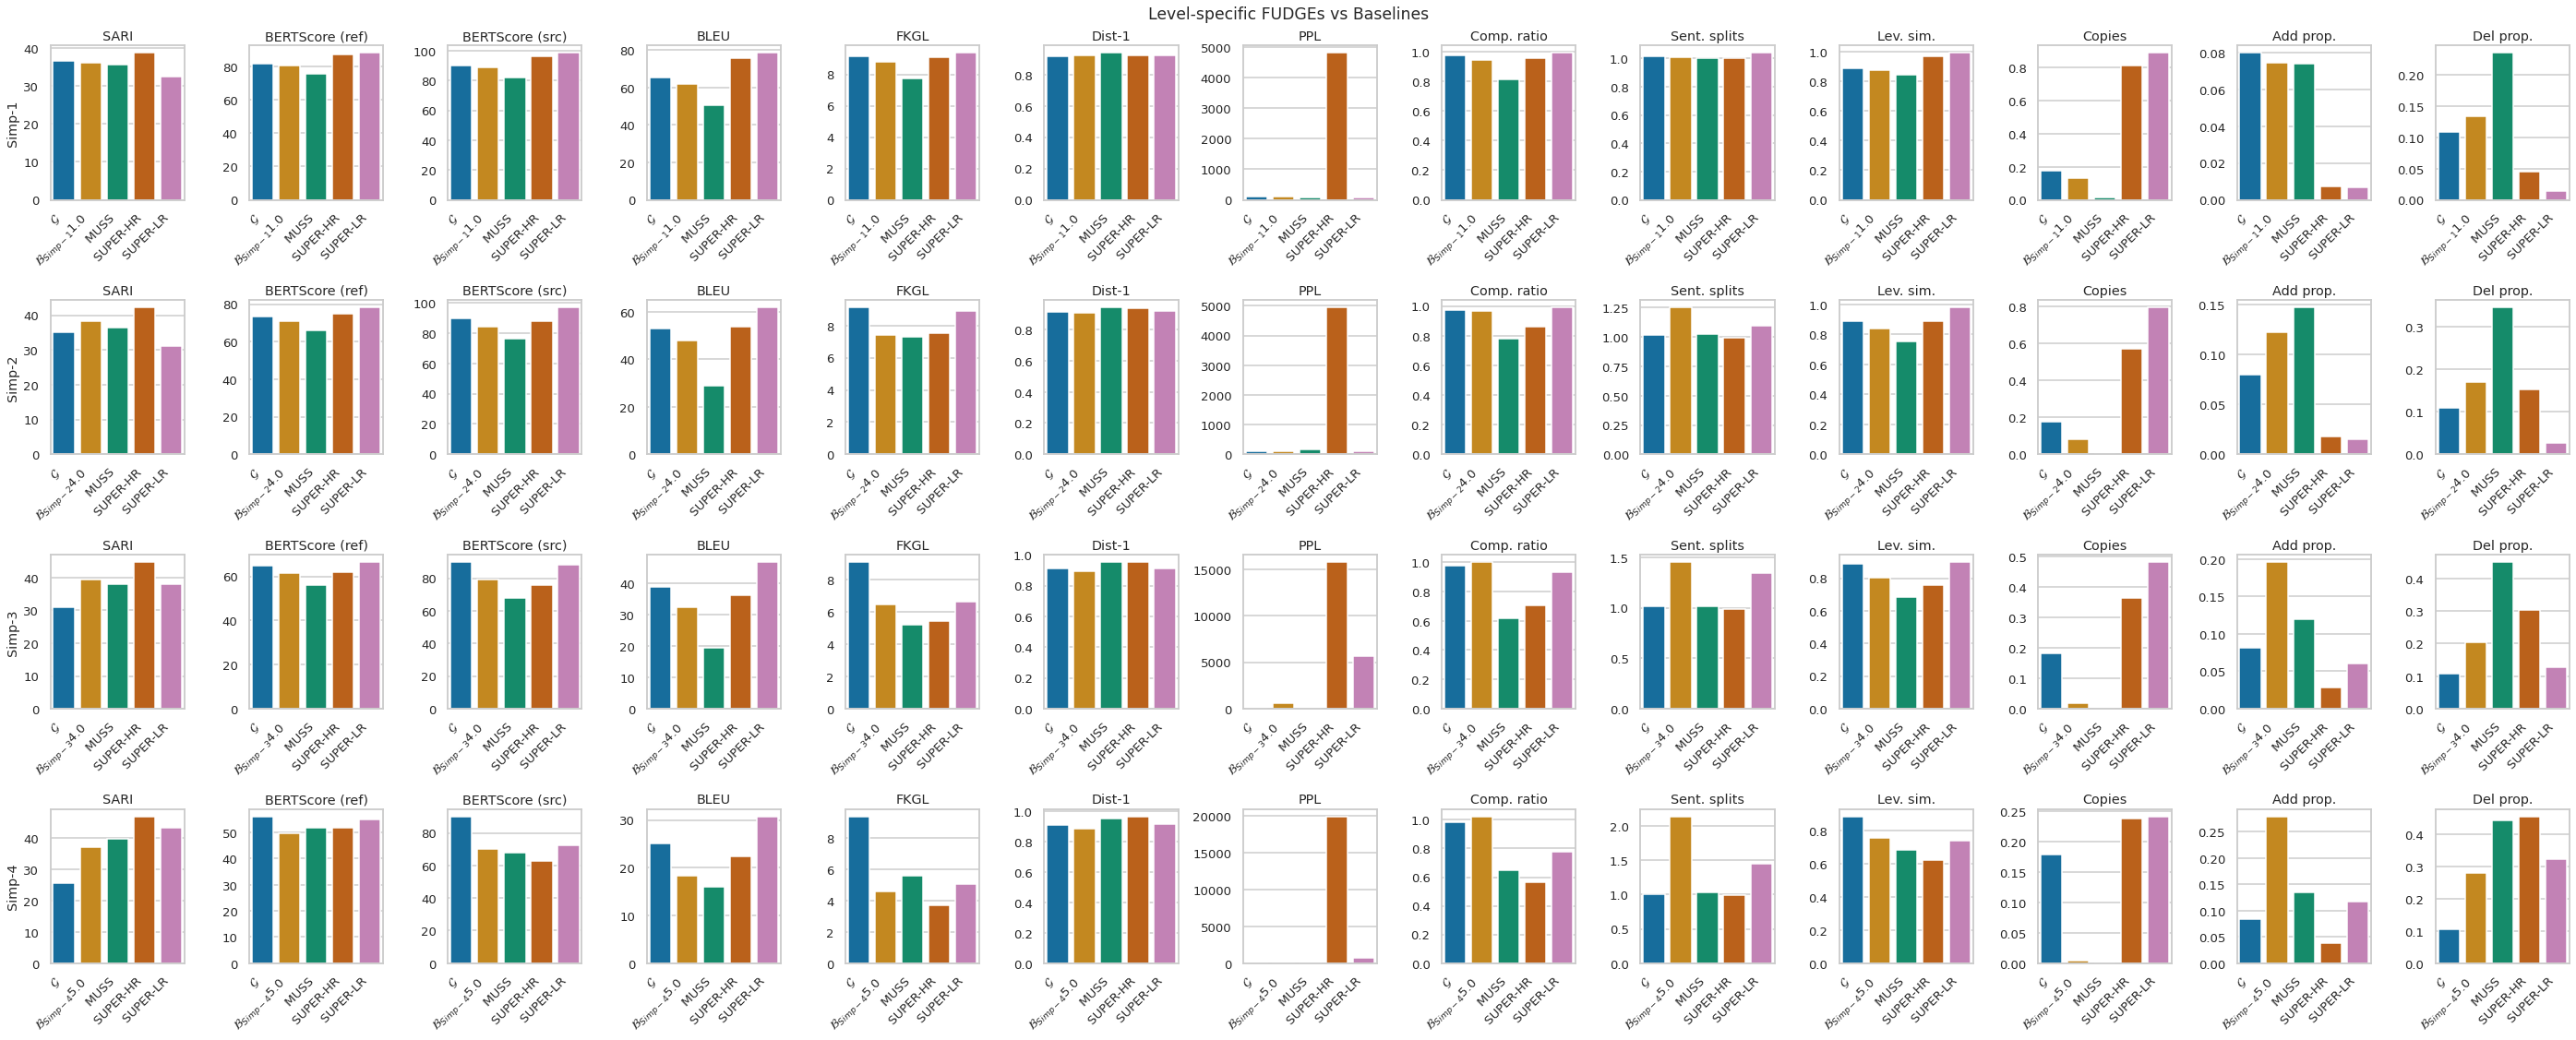

In [159]:
plot_results(df, title='Level-specific FUDGEs vs Baselines', outpath=plot_path)

20
LEVELS: ['Simp-1']
METHODS: ['PARA', '$\\mathcal{B}_{Simp-1}$', ' MUSS', 'SUPER']
20
LEVELS: ['Simp-1']
METHODS: ['PARA', '$\\mathcal{B}_{Simp-1}$', ' MUSS', 'SUPER']
20
LEVELS: ['Simp-1']
METHODS: ['PARA', '$\\mathcal{B}_{Simp-1}$', ' MUSS', 'SUPER']
20
LEVELS: ['Simp-2']
METHODS: ['PARA', '$\\mathcal{B}_{Simp-2}$', ' MUSS', 'SUPER']
20
LEVELS: ['Simp-2']
METHODS: ['PARA', '$\\mathcal{B}_{Simp-2}$', ' MUSS', 'SUPER']
20
LEVELS: ['Simp-2']
METHODS: ['PARA', '$\\mathcal{B}_{Simp-2}$', ' MUSS', 'SUPER']
20
LEVELS: ['Simp-3']
METHODS: ['PARA', '$\\mathcal{B}_{Simp-3}$', ' MUSS', 'SUPER']
20
LEVELS: ['Simp-3']
METHODS: ['PARA', '$\\mathcal{B}_{Simp-3}$', ' MUSS', 'SUPER']
20
LEVELS: ['Simp-3']
METHODS: ['PARA', '$\\mathcal{B}_{Simp-3}$', ' MUSS', 'SUPER']
20
LEVELS: ['Simp-4']
METHODS: ['PARA', '$\\mathcal{B}_{Simp-4}$', ' MUSS', 'SUPER']
20
LEVELS: ['Simp-4']
METHODS: ['PARA', '$\\mathcal{B}_{Simp-4}$', ' MUSS', 'SUPER']
20
LEVELS: ['Simp-4']
METHODS: ['PARA', '$\\mathcal{B}_{Simp-4}$'

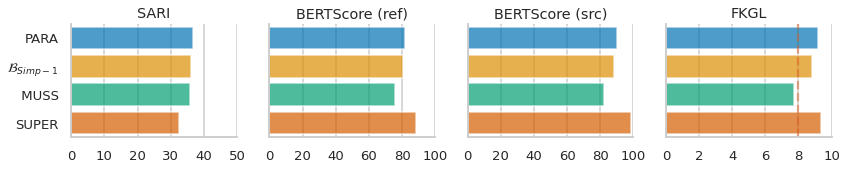

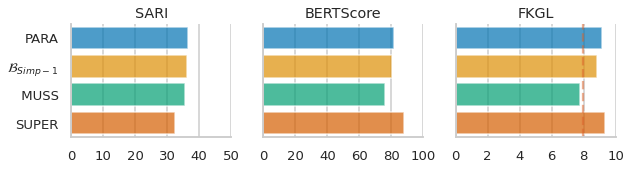

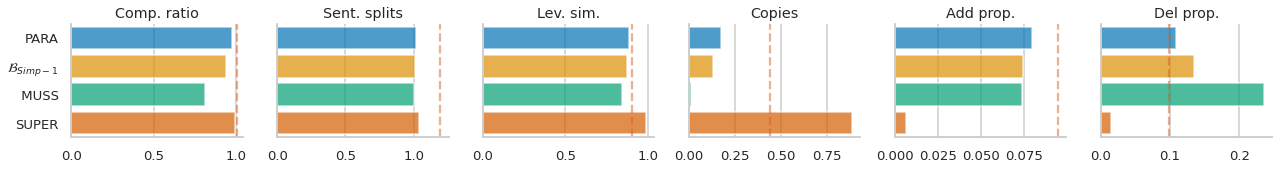

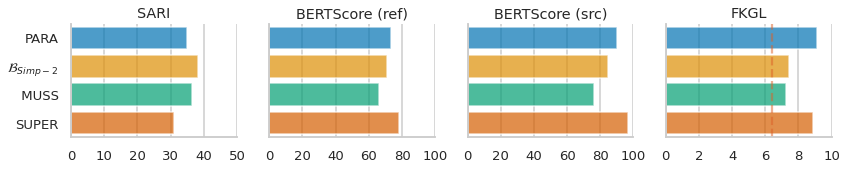

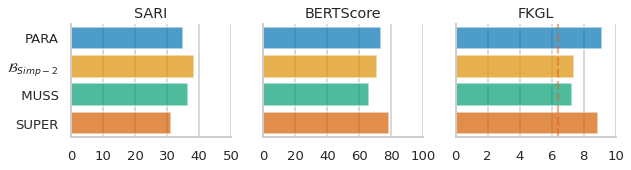

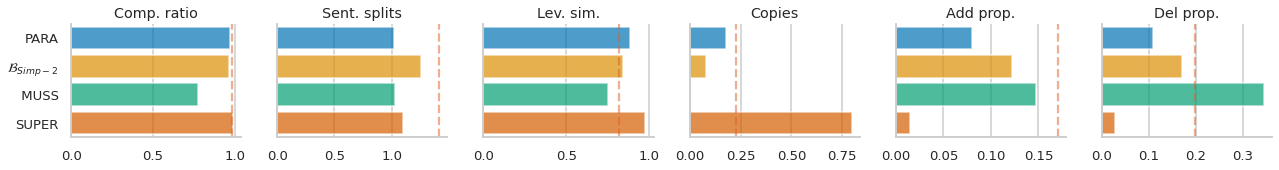

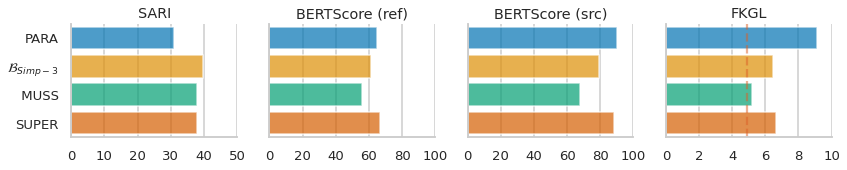

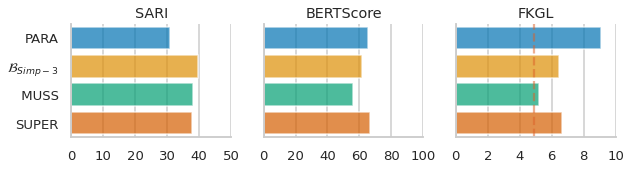

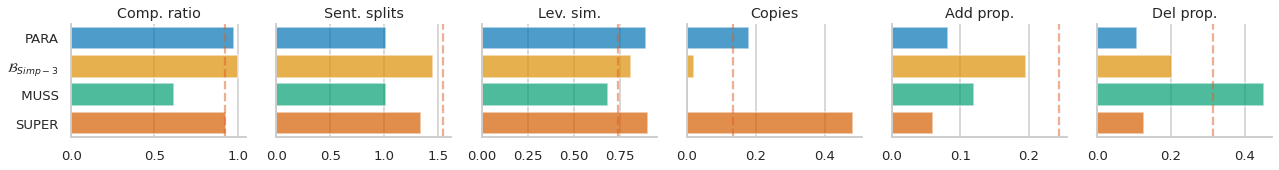

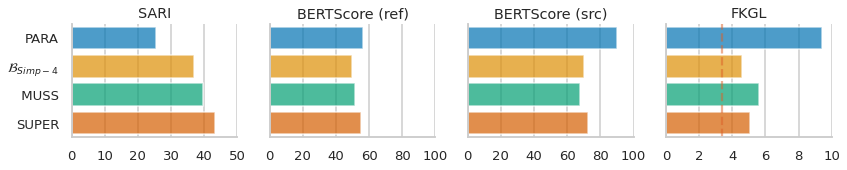

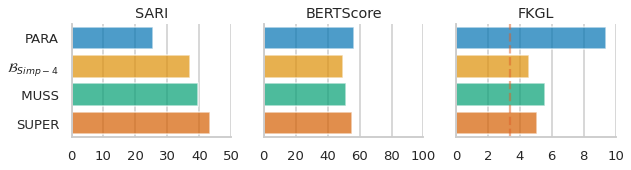

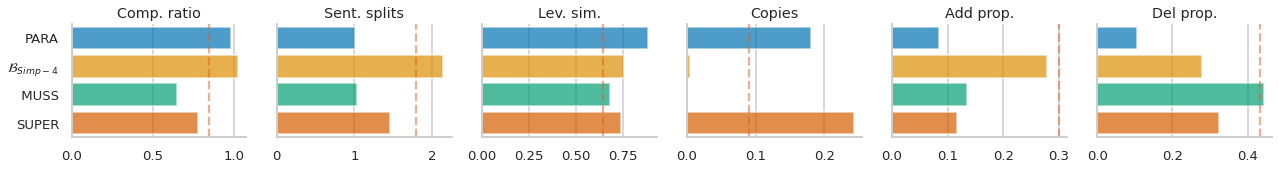

In [183]:
# added 1/11/22

name_mapping = {
    ' SUPER-LR': 'SUPER',
    '$\\mathcal{G}$': 'PARA',
    '$\\mathcal{B}_{Simp-1} $1.0': '$\mathcal{B}_{Simp-1}$',
    '$\\mathcal{B}_{Simp-2} $4.0': '$\mathcal{B}_{Simp-2}$',
    '$\\mathcal{B}_{Simp-3} $4.0': '$\mathcal{B}_{Simp-3}$',
    '$\\mathcal{B}_{Simp-4} $5.0': '$\mathcal{B}_{Simp-4}$',
}

def plot_minimal_results(df, level='Simp-2', metrics=['SARI', 'BERTScore (ref)', 'FKGL'], title='', outpath=None):
    """
    Added for generating result plots for poster/talk
    """
    palette = 'colorblind'
    sns.set_theme(context='talk', style='whitegrid', palette=palette, font='sans-serif', font_scale=0.8, rc=None)
    # sns.set_theme(context='talk', style='darkgrid', palette=palette, font='sans-serif', font_scale=0.8, rc=None)

    # cp = sns.color_palette()
    print(len(df))
    df = df[df['Target Level'] == level]
    levels = df['Target Level'].unique().tolist()
    df = df[df['Method'] != ' SUPER-HR'] # ignore high-resource setting for supervised model
    
    print('LEVELS:', levels)
    # print('METHODS:', df['Method'].unique().tolist())
    df['Method'] = df['Method'].apply(lambda x: name_mapping.get(x, x))
    print('METHODS:', df['Method'].unique().tolist())

    # cols = df.select_dtypes(include=np.number).columns.tolist()
    # cols.remove('Lexical complexity score')
    # cols.remove('intra_dist2')
    # cols.remove('Levenshtein similarity')
    # cols.remove('bertscore_f1_src')


    # fig, axes = plt.subplots(len(metrics), len(levels), figsize=(4*len(levels), 2.5*len(metrics)), tight_layout=True)
    fig, axes = plt.subplots(len(levels), len(metrics), figsize=(3*len(metrics), 2.6*len(levels)), sharey = True, tight_layout=True)

    for i, col in enumerate(metrics):
        sub_df = df[df['Target Level'] == level]
            
        # sns.barplot(y=col, x='Method', data=sub_df, ax=axes[i], palette=cp) # vertical
        bar = sns.barplot(x=col, y='Method', data=sub_df, ax=axes[i], alpha=0.7, saturation=2.0,) # horizontal
        
        axes[i].set_xlabel(None)

        # swap ylabel for axis title
        axes[i].set_title(col)
        axes[i].set_ylabel(None)
    
        if col not in ['SARI', 'BERTScore (ref)', 'BERTScore (src)']:
            ground_truth_val = ground_truth[level].get(col)
            if ground_truth_val:
                axes[i].axvline(x=ground_truth_val, alpha=0.5, linestyle='--', label='ground truth', color='#dc6027')
        
        if col == 'SARI':
            axes[i].set_xlim(0, 50)
            axes[i].set_xticks(range(51)[::10])
        
        if col == 'BERTScore (ref)':
            axes[i].set_xlim(0, 100)
            axes[i].set_xticks(range(101)[::20])
            if 'BERTScore (src)' not in metrics:
                axes[i].set_title('BERTScore')

        if col == 'BERTScore (src)':
            axes[i].set_xlim(0, 100)
            axes[i].set_xticks(range(101)[::20])

        if col == 'FKGL':
            axes[i].set_xlim(0, 10)
            axes[i].set_xticks(range(11)[::2])
        # if i == 0:
        #     axes[i].set_ylabel(level)
            
#         axes[i][0].set_title()

        # bar.patches[1].set_edgecolor('#00FFFF')
        # bar.patches[1].set_linewidth(2)
        # bar.patches[1].set_hatch('/')
        # patch_h = [patch.get_height() for patch in bar.patches]   
        # # patch_h contains the heights of all the patches now

        # idx_tallest = np.argmax(patch_h)   
        # # np.argmax return the index of largest value of the list
        # bar.patches[idx_tallest].set_facecolor('#a834a8')



    # fig.suptitle(level)
    
    sns.despine(right=True, bottom = False, left = False, top=True)

    if outpath and title:
        plt.savefig(outpath / f'{title.replace(" ", "_").lower()}.pdf', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)
        plt.savefig(outpath / f'{title.replace(" ", "_").lower()}.png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)
    
    return

plot_minimal_results(df, level='Simp-1', metrics=['SARI', 'BERTScore (ref)', 'BERTScore (src)', 'FKGL'], title='Simp-1_full_results', outpath=plot_path)
plot_minimal_results(df, level='Simp-1', metrics=['SARI', 'BERTScore (ref)', 'FKGL'], title='Simp-1_main_results', outpath=plot_path)
plot_minimal_results(df, level='Simp-1', metrics=[
    'Comp. ratio', 'Sent. splits', 'Lev. sim.', 'Copies', 
    'Add prop.', 'Del prop.',
    ], 
    title='Simp-1_stat_results', outpath=plot_path)

plot_minimal_results(df, level='Simp-2', metrics=['SARI', 'BERTScore (ref)', 'BERTScore (src)', 'FKGL'], title='Simp-2_full_results', outpath=plot_path)
plot_minimal_results(df, level='Simp-2', metrics=['SARI', 'BERTScore (ref)', 'FKGL'], title='Simp-2_main_results', outpath=plot_path)
plot_minimal_results(df, level='Simp-2', metrics=[
    'Comp. ratio', 'Sent. splits', 'Lev. sim.', 'Copies', 
    'Add prop.', 'Del prop.',
    ], 
    title='Simp-2_stat_results', outpath=plot_path)

plot_minimal_results(df, level='Simp-3', metrics=['SARI', 'BERTScore (ref)', 'BERTScore (src)', 'FKGL'], title='Simp-3_full_results', outpath=plot_path)
plot_minimal_results(df, level='Simp-3', metrics=['SARI', 'BERTScore (ref)', 'FKGL'], title='Simp-3_main_results', outpath=plot_path)
plot_minimal_results(df, level='Simp-3', metrics=[
    'Comp. ratio', 'Sent. splits', 'Lev. sim.', 'Copies', 
    'Add prop.', 'Del prop.',
    ], 
    title='Simp-3_stat_results', outpath=plot_path)

plot_minimal_results(df, level='Simp-4', metrics=['SARI', 'BERTScore (ref)', 'BERTScore (src)', 'FKGL'], title='Simp-4_full_results', outpath=plot_path)
plot_minimal_results(df, level='Simp-4', metrics=['SARI', 'BERTScore (ref)', 'FKGL'], title='Simp-4_main_results', outpath=plot_path)
plot_minimal_results(df, level='Simp-4', metrics=[
    'Comp. ratio', 'Sent. splits', 'Lev. sim.', 'Copies', 
    'Add prop.', 'Del prop.',
    ], 
    title='Simp-4_stat_results', outpath=plot_path)